https://www.mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/

# Jak przewidzieć wiele szeregów czasowych jednocześnie za pomocą Scikit-Learn (z przykładem prognozowania sprzedaży)

Masz wiele punktów danych szeregów czasowych i chcesz przewidzieć następny krok (lub kroki). Co powinieneś teraz zrobić? Wytrenuj model dla każdej serii? Czy jest sposób na dopasowanie modelu do wszystkich serii razem? Co jest lepsze?

Widziałem wielu analityków danych, którzy zastanawiali się nad podejściem do tego problemu, tworząc jeden model dla każdego produktu. Chociaż jest to jedno z możliwych rozwiązań, prawdopodobnie nie będzie najlepsze.

W tym miejscu pokażę, jak wytrenować pojedynczy model do prognozowania wielu szeregów czasowych w tym samym czasie. Ta technika zwykle tworzy potężne modele, które pomagają zespołom wygrywać konkursy na uczenie maszynowe i można je wykorzystać w projekcie.

I nie potrzebujesz do tego modeli głębokiego uczenia!

# Indywidualne modele uczenia maszynowego a duży model dla wszystkiego

W uczeniu maszynowym więcej danych zwykle oznacza lepsze prognozy. Jeśli spróbujesz stworzyć jeden model dla każdej serii, będziesz miał pewne problemy z seriami, które zawierają niewiele danych lub nie zawierają ich wcale.

Gdy łączysz wszystkie serie w jeden zestaw danych, aby wytrenować jeden model, używasz znacznie więcej danych. Może to pomóc modelowi lepiej działać!

Biorąc pod uwagę więcej niż jedną serię na raz, algorytmy uczenia maszynowego będą w stanie nauczyć się bardziej subtelnych wzorców, które powtarzają się w różnych seriach. Produkt staje się zmienną w naszym modelu.

Najpierw zaimportujmy nasze podstawowe narzędzia:

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor



df = pd.read_csv("/media/wojciech/D6DE33C1DE339927/1A/Sales_Transactions_Dataset_Weekly.csv")
#print(is.data.frame(df))
#print(ncol(df))
#print(nrow(df))
#print(names(df))
df

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,Normalized 42,Normalized 43,Normalized 44,Normalized 45,Normalized 46,Normalized 47,Normalized 48,Normalized 49,Normalized 50,Normalized 51
0,P1,11,12,10,8,13,12,14,21,6,...,0.06,0.22,0.28,0.39,0.50,0.00,0.22,0.17,0.11,0.39
1,P2,7,6,3,2,7,1,6,3,3,...,0.20,0.40,0.50,0.10,0.10,0.40,0.50,0.10,0.60,0.00
2,P3,7,11,8,9,10,8,7,13,12,...,0.27,1.00,0.18,0.18,0.36,0.45,1.00,0.45,0.45,0.36
3,P4,12,8,13,5,9,6,9,13,13,...,0.41,0.47,0.06,0.12,0.24,0.35,0.71,0.35,0.29,0.35
4,P5,8,5,13,11,6,7,9,14,9,...,0.27,0.53,0.27,0.60,0.20,0.20,0.13,0.53,0.33,0.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806,P815,0,0,1,0,0,2,1,0,0,...,0.00,0.33,0.33,0.00,0.00,0.33,0.00,0.00,0.67,0.00
807,P816,0,1,0,0,1,2,2,6,0,...,0.43,0.43,0.57,0.29,0.57,0.71,0.71,0.71,0.86,0.71
808,P817,1,0,0,0,1,1,2,1,1,...,0.50,0.00,0.00,0.50,0.50,0.00,0.00,0.00,1.00,0.75
809,P818,0,0,0,1,0,0,0,0,1,...,0.00,0.00,0.00,0.50,0.50,0.00,0.00,0.00,1.00,0.00


# Przygotowanie danych
Dane zostały pozyskane z Repozytorium UCI.

Tutaj postaramy się prognozować sprzedaż dla 811 produktów. Nasz zbiór danych zawiera rekordy sprzedaży z 52 tygodni dla każdego z produktów.

Oznacza to, że pierwotnie mamy 811 szeregów czasowych z 52 punktami danych każdy. Tutaj biorę tylko kod produktu i nieznormalizowaną tygodniową sprzedaż dla każdego produktu.

Tak wyglądają dane:

In [2]:
data = pd.read_csv("/media/wojciech/D6DE33C1DE339927/1A/Sales_Transactions_Dataset_Weekly.csv")
data = data.filter(regex=r'Product|W')
data.head()

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
0,P1,11,12,10,8,13,12,14,21,6,...,4,7,8,10,12,3,7,6,5,10
1,P2,7,6,3,2,7,1,6,3,3,...,2,4,5,1,1,4,5,1,6,0
2,P3,7,11,8,9,10,8,7,13,12,...,6,14,5,5,7,8,14,8,8,7
3,P4,12,8,13,5,9,6,9,13,13,...,9,10,3,4,6,8,14,8,7,8
4,P5,8,5,13,11,6,7,9,14,9,...,7,11,7,12,6,6,5,11,8,9


W tym momencie wielu analityków danych próbowałoby dopasować model do każdego produktu. I chociaż może to działać dobrze, możemy mieć problemy z powodu posiadania tylko 52 punktów danych dla każdego modelu, co jest naprawdę niskie!

Ponieważ modele uczenia maszynowego mają tendencję do ulepszania się przy większej ilości danych, dlaczego nie spróbować połączyć wszystkich serii i wytrenować jednego modelu z większą ilością danych?

Aby to zrobić, musimy „stopić” dane. Oznacza to po prostu przekształcenie danych w taki sposób, w jaki każda linia staje się: kodem produktu, tygodniem, sprzedażą

Aby ułatwić nam życie, postanowiłem usunąć litery z kodu produktu i tygodnia.

In [3]:
melt = data.melt(id_vars='Product_Code', var_name='Week', value_name='Sales')
melt

,Product_Code,Week,Sales
0,P1,W0,11
1,P2,W0,7
2,P3,W0,7
3,P4,W0,12
4,P5,W0,8
...,...,...,...
42167,P815,W51,0
42168,P816,W51,5
42169,P817,W51,3
42170,P818,W51,0


In [4]:
melt['Product_Code'] = melt['Product_Code'].str.extract('(\d+)', expand=False).astype(int)
melt['Product_Code']

0          1
1          2
2          3
3          4
4          5
        ... 
42167    815
42168    816
42169    817
42170    818
42171    819
Name: Product_Code, Length: 42172, dtype: int64

In [5]:
melt

,Product_Code,Week,Sales
0,1,W0,11
1,2,W0,7
2,3,W0,7
3,4,W0,12
4,5,W0,8
...,...,...,...
42167,815,W51,0
42168,816,W51,5
42169,817,W51,3
42170,818,W51,0


In [6]:
melt['Week'] = melt['Week'].str.extract('(\d+)', expand=False).astype(int)
melt

,Product_Code,Week,Sales
0,1,0,11
1,2,0,7
2,3,0,7
3,4,0,12
4,5,0,8
...,...,...,...
42167,815,51,0
42168,816,51,5
42169,817,51,3
42170,818,51,0


In [7]:
melt = melt.sort_values(['Week', 'Product_Code'])
melt.head()

,Product_Code,Week,Sales
0,1,0,11
1,2,0,7
2,3,0,7
3,4,0,12
4,5,0,8


In [8]:
melt.shape

(42172, 3)

Teraz mamy 42172 wiersze do trenowania naszego modelu.

# Podstawowa inżynieria funkcji

Potrzebujemy zmiennych do wysłania do naszego modelu i uzyskania prognoz. 
Na razie, oprócz kodu produktu i tygodnia, stworzę dwie funkcje, które zwykle bardzo pomagają w prognozowaniu szeregów czasowych: opóźnienia i różnice.

Sprzedaż w zeszłym tygodniu: jest to po prostu kwota sprzedaży, jaką produkt miał w poprzednim tygodniu
Różnica z ostatniego tygodnia: różnica między wielkością sprzedaży w poprzednim tygodniu i tygodniu poprzedzającym (t-1 - t-2)

In [9]:
melt2 = melt.copy() ## skopiował df

In [10]:
melt2['Last_Week_Sales'] = melt2.groupby(['Product_Code'])['Sales'].shift() ## zrobił przesunięcie o jeden
#df[df.iso_country.isin(['CZ','SK','PL'])&(df.type =='large_airport')]

melt2[melt2.Week.isin([7,8,9,10,11,12,13])&(melt2.Product_Code ==2)][['Product_Code','Sales','Last_Week_Sales']] 
#melt2[['Sales','Last_Week_Sales']]

,Product_Code,Sales,Last_Week_Sales
5678,2,3,6.0
6489,2,3,3.0
7300,2,3,3.0
8111,2,2,3.0
8922,2,2,2.0
9733,2,6,2.0
10544,2,2,6.0


In [11]:
melt2['Last_Week_Diff'] = melt2.groupby(['Product_Code'])['Last_Week_Sales'].diff() # różnica między kolejnymi dniami np. 6-2 = 4

In [12]:
melt2[melt2.Week.isin([7,8,9,10,11,12,13])&(melt2.Product_Code ==2)]

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff
5678,2,7,3,6.0,5.0
6489,2,8,3,3.0,-3.0
7300,2,9,3,3.0,0.0
8111,2,10,2,3.0,0.0
8922,2,11,2,2.0,-1.0
9733,2,12,6,2.0,0.0
10544,2,13,2,6.0,4.0


In [13]:
melt2.head()

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff
0,1,0,11,NaN,NaN
1,2,0,7,NaN,NaN
2,3,0,7,NaN,NaN
3,4,0,12,NaN,NaN
4,5,0,8,NaN,NaN


In [14]:
melt2 = melt2.dropna()  # wykasowane wszystkie wiersze zawierające NaN
melt2.head()

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff
1622,1,2,10,12.0,1.0
1623,2,2,3,6.0,-1.0
1624,3,2,8,11.0,4.0
1625,4,2,13,8.0,-4.0
1626,5,2,13,5.0,-3.0


In [15]:
stop

NameError: name 'stop' is not defined

# Ocena wyniku

Aby wiedzieć, czy nasz model jest dobry, potrzebujemy metryki oceny. Miarą, którą bardzo lubię w prognozowaniu sprzedaży, jest błąd logarytmu średniokwadratowego.

To jest nasz dobrze znany RMSE zastosowany do dziennika celu i wyniku prognozy.

Działa jako przybliżenie błędu procentowego między naszym modelem prognozowania a wartością docelową, co jest dobrym sposobem na zrozumienie błędów popełnianych przez nasz model.

In [17]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

# Ustawianie linii bazowej i podziału walidacji

Załóżmy, że w prawdziwym życiu Twój model będzie działał w każdą niedzielę wieczorem, aby już w poniedziałek menedżerowie mogli podejmować decyzje na podstawie przewidywań na następny tydzień.

Aby sprawdzić, czy nasz model będzie działał w tym scenariuszu, tygodni, których wcześniej nie widział, użyję walidacji z przesuwnym oknem.

### Oznacza to, że będziemy symulować trenowanie modelu we wszystkich tygodniach aż do tego, który chcemy prognozować i oceniać nasz wynik w nowym tygodniu.

Aby uniknąć posiadania bardzo dobrego modelu w ciągu niewielkiej liczby tygodni, po prostu ze względu na szczęście, będę używał tygodni od 40 do 52, powtarzając proces dla jednego na raz (za kazdym razem) i obliczając wynik.

Ponieważ jest to tylko demonstracja metody, dla uproszczenia nie oddzielam zestawu testowego. W swoich projektach zawsze trzymaj pewne okresy poza walidacją, aby ocenić swój model po zakończeniu jego opracowywania.

Jest to bardzo ważne i zapewnia większe bezpieczeństwo podczas wdrażania modelu.

Aby upewnić się, że model jest wart zastosowania, lubię ustalać punktację bazową, którą musi pokonać. W tym przypadku dość silna linia bazowa wykorzystuje sprzedaż z ostatniego tygodnia jako prognozę sprzedaży w tym tygodniu.

In [27]:
for week in range(4,5):
    train = melt2[melt2['Week'] < week] ## wszystkie weekendy porzed 4 weekendem
    val = melt2[melt2['Week'] == week]  ## wszystkie weekendy mniejsze do 5 i równe 4
train

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff
1622,1,2,10,12.0,1.0
1623,2,2,3,6.0,-1.0
1624,3,2,8,11.0,4.0
1625,4,2,13,8.0,-4.0
1626,5,2,13,5.0,-3.0
...,...,...,...,...,...
3239,815,3,0,1.0,1.0
3240,816,3,0,0.0,-1.0
3241,817,3,0,0.0,0.0
3242,818,3,1,0.0,0.0


In [26]:
val  # wszystkie weekendy mniejsze do 5 i równe 4

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff
3244,1,4,13,8.0,-2.0
3245,2,4,7,2.0,-1.0
3246,3,4,10,9.0,1.0
3247,4,4,9,5.0,-8.0
3248,5,4,6,11.0,-2.0
...,...,...,...,...,...
4050,815,4,0,0.0,-1.0
4051,816,4,1,0.0,0.0
4052,817,4,1,0.0,0.0
4053,818,4,0,1.0,1.0


In [18]:
mean_error = []
for week in range(40,52):
    train = melt2[melt2['Week'] < week]  ## wszystkie weekendy porzed 40 weekendem
    val = melt2[melt2['Week'] == week]   ## wszystkie weekendy od 40 do 51 weekend

    p = val['Last_Week_Sales'].values

    error = rmsle(val['Sales'].values, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 40 - Error 0.51952
Week 41 - Error 0.51691
Week 42 - Error 0.51026
Week 43 - Error 0.50792
Week 44 - Error 0.53409
Week 45 - Error 0.52347
Week 46 - Error 0.50018
Week 47 - Error 0.49138
Week 48 - Error 0.50585
Week 49 - Error 0.50547
Week 50 - Error 0.52220
Week 51 - Error 0.55242
Mean Error = 0.51581


Teraz wiemy, że nasz model musi mieć lepszy błąd niż około 0,51. Byłoby to około 50% błędu w każdej prognozie, co wydaje się ogromne! Ale czy to naprawdę?

Jeśli przyjrzymy się rozkładowi sprzedaży w zbiorze danych, zobaczymy, że wiele przedmiotów sprzedaje bardzo małe ilości. Powinniśmy więc oczekiwać, że błąd będzie wyglądał na „wysoki”.

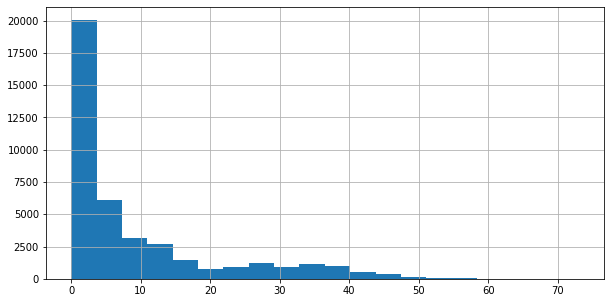

In [19]:
melt2['Sales'].hist(bins=20, figsize=(10,5))

# Tworzenie modelu

Teraz, gdy mamy linię bazową, spróbujmy ją pokonać!

Jako pierwszy model wytrenujmy Losowy Las. Poza tym, że jesteśmy silnym modelem z ustrukturyzowanymi danymi (takimi jak ten, które mamy), zwykle możemy już uzyskać bardzo dobry wynik, po prostu ustawiając dużą liczbę drzew.

Zwykle mówię analitykom danych, że Losowy Las to bardzo dobry model do wykorzystania w leniwy dzień. Ustawiasz tylko liczbę drzew na maksymalną, którą twój komputer może uruchomić i uzyskać dobry model (miejmy nadzieję).

Zostanę Tydzień jako funkcję, chociaż nasz model nigdy nie widział nowej wartości tygodnia. Może się zdarzyć, że np. po 35 tygodniu mamy większą sprzedaż produktu. Ten rodzaj efektu może zostać uchwycony przez model.

Ponieważ drzewa decyzyjne dobrze radzą sobie z cechami kategorialnymi nawet w kodowaniu porządkowym, zostawiłem je w tym formacie.

W każdym razie bądź ostrożny z tego typu funkcjami.



In [ ]:
mean_error = []
for week in range(40,52):
    train = melt2[melt2['Week'] < week]
    val = melt2[melt2['Week'] == week]

    xtr, xts = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, val['Sales'].values

    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)

    p = mdl.predict(xts)

    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

# SUPER!

Stosując Losowy Las do naszych początkowych zmiennych, uzyskaliśmy dobrą redukcję błędu (około 10%). To bardzo dobry sposób na rozpoczęcie.

Teraz spróbujmy dodać kilka funkcji sprzed kilku tygodni. Najpierw dodajmy opóźnienie i różnicę sprzedaży na tydzień przed poprzednim.

In [ ]:
melt3 = melt.copy()
melt3['Last_Week_Sales'] = melt3.groupby(['Product_Code'])['Sales'].shift()
melt3['Last_Week_Diff'] = melt3.groupby(['Product_Code'])['Last_Week_Sales'].diff()
melt3['Last-1_Week_Sales'] = melt3.groupby(['Product_Code'])['Sales'].shift(2)
melt3['Last-1_Week_Diff'] = melt3.groupby(['Product_Code'])['Last-1_Week_Sales'].diff()
melt3 = melt3.dropna()
melt3.head()

In [ ]:
mean_error = []
for week in range(40,52):
    train = melt3[melt3['Week'] < week]
    val = melt3[melt3['Week'] == week]

    xtr, xts = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, val['Sales'].values

    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)

    p = mdl.predict(xts)

    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

# WspaniaLE! Kolejna obniżka!

Czy możesz odgadnąć mój następny pomysł?

Wypróbujmy oczywiście model z jeszcze jednym opóźnieniem i różnicą!

In [ ]:
melt4 = melt.copy()
melt4['Last_Week_Sales'] = melt4.groupby(['Product_Code'])['Sales'].shift()
melt4['Last_Week_Diff'] = melt4.groupby(['Product_Code'])['Last_Week_Sales'].diff()
melt4['Last-1_Week_Sales'] = melt4.groupby(['Product_Code'])['Sales'].shift(2)
melt4['Last-1_Week_Diff'] = melt4.groupby(['Product_Code'])['Last-1_Week_Sales'].diff()
melt4['Last-2_Week_Sales'] = melt4.groupby(['Product_Code'])['Sales'].shift(3)
melt4['Last-2_Week_Diff'] = melt4.groupby(['Product_Code'])['Last-2_Week_Sales'].diff()
melt4 = melt4.dropna()
melt4.head()

In [ ]:
mean_error = []
for week in range(40,52):
    train = melt4[melt4['Week'] < week]
    val = melt4[melt4['Week'] == week]

    xtr, xts = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, val['Sales'].values

    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)

    p = mdl.predict(xts)

    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Zgodnie z oczekiwaniami błąd jest zmniejszony.

Zatrzymam tutaj tworzenie opóźnień i różnic, ponieważ zaczynam się powtarzać, ale możesz wypróbować więcej opóźnień, różnic, a nawet innych funkcji, aby zobaczyć, kiedy przestaną się poprawiać.

# Zmiana funkcji straty (i dystrybucji docelowej)

Oceniamy nasze wyniki za pomocą dziennika naszych przewidywań i celu, ale trenujemy przy użyciu ich w ich oryginalnej formie, więc optymalizujemy model przy użyciu MSE zamiast MSLE.

Zwykle uzyskujesz poprawę, używając tej samej funkcji do oceny i optymalizacji modelu. W tym przypadku możemy to zrobić, po prostu biorąc dziennik naszej zmiennej docelowej przed przekazaniem go do modelu dopasowania.

Czasami nie jest możliwa bezpośrednia optymalizacja funkcji oceny. W takim przypadku poszukaj przybliżenia. Można powiedzieć, że już tutaj stosujemy przybliżenie (błędu procentowego).

Biorąc dziennik celu, otrzymujemy dodatkową premię, że jego dystrybucja będzie wyglądać bliższa normalnej dystrybucji. Zwykle pomaga to modelowi lepiej się uczyć.

In [ ]:
mean_error = []
for week in range(40,52):
    train = melt4[melt4['Week'] < week]
    val = melt4[melt4['Week'] == week]

    xtr, xts = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, val['Sales'].values

    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, np.log1p(ytr))

    p = np.expm1(mdl.predict(xts))

    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Yes! Lower error!

# Lepszy model
Każdy, kto kiedykolwiek natknął się na rozwiązanie konkurencji oparte na uczeniu maszynowym, może wiedzieć o zamiłowaniu konkurentów do drzew ze wzmocnieniem gradientowym. Ja też jestem tego winny!

Bardzo często osiąga się najlepsze wyniki w przypadku tego typu modelu, który jest zespołem drzew, takim jak losowy las, ale metoda używana do tworzenia i łączenia drzew jest inna. Warto zrozumieć.

To bardzo dobry scenariusz dla nas, aby wypróbować ten model i sprawdzić, czy możemy jeszcze bardziej zmniejszyć błąd!

Istnieje wiele parametrów, które możemy dostroić do tego modelu, ale po prostu umieszczę 1000 drzew z małym tempem uczenia się. Jeśli chcesz poprawić prognozę, możesz spróbować ją dostroić i zostawić komentarz na temat uzyskanej poprawy.

In [ ]:
mean_error = []
for week in range(40,52):
    train = melt4[melt4['Week'] < week]
    val = melt4[melt4['Week'] == week]

    xtr, xts = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, val['Sales'].values

    mdl = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdl.fit(xtr, np.log1p(ytr))

    p = np.expm1(mdl.predict(xts))

    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

# Bardzo dobrze!

Ten model dał nam sporą poprawę, jesteśmy prawie poniżej bariery 0,40. Rzućmy okiem na nasze prognozy na tydzień 52.

In [ ]:
val.loc[:, 'Prediction'] = np.round(p)
val.plot.scatter(x='Prediction', y='Sales', figsize=(15,10), title='Prediction vs Sales', 
                 ylim=(0,40), xlim=(0,40))

Nasz model radzi sobie całkiem nieźle w przypadku produktów, których sprzedaż wynosi poniżej około 25 sztuk.

Ale widzimy „klaster” produktów, które mają około 30 sprzedaży dziennie, gdzie nasz model jest zaniżony. Powinniśmy zdecydowanie zbadać tę grupę, zrozumieć, dlaczego tak się dzieje i sprawdzić, czy możemy to naprawić.

Czy brakuje nam informacji? Może są to produkty kupowane hurtowo? A może jednostki są różne (funty vs uncje)?

Teraz, aby uzyskać prognozy dla każdej serii, wystarczy umieścić kod produktu, tydzień i obliczyć nowe funkcje.

Pamiętasz naszą linię podstawową przy RMSLE 0.51581? Poprawiliśmy go do 0,4063, co oznacza 21% redukcję błędów!

# Ulepszanie rozwiązania
Kilka pomysłów, które możesz spróbować ulepszyć to rozwiązanie:

Zbadaj produkty, których sprzedaż przekracza 25 sztuk.
Wypróbuj więcej funkcji (opóźnień, różnic) nie tylko na poziomie produktu, ale także na całym świecie.
Spróbuj użyć natywnej obsługi LightGBM dla funkcji kategorycznych za pomocą kodu produktu.
Spróbuj dostroić hiperparametry modelu.
Wypróbuj sieć neuronową i połącz z GBM.

In [ ]:
/Users/mnestevao/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s